In [50]:
import numpy as np

In [51]:
def lu_decomposition(A, pivoting=False):
    A = np.array(A, dtype=float)
    n = A.shape[0]
    # Macierz permutacyjna – początkowo jednostkowa
    P = np.eye(n)
    # Macierz dolnotrójkątna – początkowo jednostkowa
    L = np.eye(n)
    # Kopia A, bo będziemy modyfikować U
    U = A.copy()

    for i in range(n):
        if pivoting:
            # Znalezienie indeksu największego elementu w aktualnej kolumnie poniżej przekątnej
            max_index = np.argmax(abs(U[i:, i])) + i

            # Zamiana wierszy
            if max_index != i:
                U[[i, max_index]] = U[[max_index, i]]
                P[[i, max_index]] = P[[max_index, i]]
                if i > 0:  # Zamiana tylko wcześniejszych kolumn w L
                    L[[i, max_index], :i] = L[[max_index, i], :i]

        for j in range(i + 1, n):
            # Obliczenie współczynnika eliminacji
            L[j, i] = U[j, i] / U[i, i]
            # Aktualizacja macierzy U
            U[j, i:] -= L[j, i] * U[i, i:]

    if pivoting:
        return P, L, U
    else:
        return L, U

In [52]:
def solve_lu(A, b, pivoting=False):
    b = np.array(b, dtype=float)
    if pivoting:
        P, L, U = lu_decomposition(A, pivoting=True)
        b = np.dot(P, b)
    else:
        L, U = lu_decomposition(A, pivoting=False)

    # Rozwiązanie Lc = b (podstawianie w przód)
    n = len(b)
    c = np.zeros(n)
    for i in range(n):
        c[i] = b[i] - np.dot(L[i, :i], c[:i])

    # Rozwiązanie Ux = c (podstawianie wstecz)
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = (c[i] - np.dot(U[i, i + 1 :], x[i + 1 :])) / U[i, i]

    return x

In [53]:
A = np.array([[2, 1, -1], [-3, -1, 2], [-2, 1, 2]])
b = np.array([8, -11, -3])

x = solve_lu(A, b, pivoting=False)
print("Rozwiązanie układu równań (LU bez pivotingu):", x)

x = solve_lu(A, b, pivoting=True)
print("Rozwiązanie układu równań (LU z pivotingiem):", x)

Rozwiązanie układu równań (LU bez pivotingu): [ 2.  3. -1.]
Rozwiązanie układu równań (LU z pivotingiem): [ 2.  3. -1.]


In [54]:
def gauss_elimination_no_pivoting(A, b):
    """
    Rozwiązuje układ równań Ax = b za pomocą eliminacji Gaussa bez pivotingu,
    generując jedynki na przekątnej.

    Parametry:
    A -- macierz współczynników (n x n)
    b -- wektor prawych stron (n)

    Zwraca:
    x -- wektor rozwiązania
    """
    n = len(A)
    A = np.array(
        A, dtype=float
    )  # Konwersja na float, aby uniknąć dzielenia całkowitego
    b = np.array(b, dtype=float)

    # --- Eliminacja współczynników pod przekątną ---
    for k in range(n - 1):  # Dla każdej kolumny (oprócz ostatniej)
        for i in range(k + 1, n):  # Dla każdego wiersza poniżej przekątnej
            if A[k, k] == 0:
                raise ZeroDivisionError(
                    "Wystąpiło dzielenie przez zero. Użyj pivotingu!"
                )
            factor = A[i, k] / A[k, k]
            A[i, k:] -= factor * A[k, k:]  # Aktualizacja wiersza i-tego
            b[i] -= factor * b[k]

    # --- Normalizacja, aby uzyskać jedynki na przekątnej ---
    for k in range(n):
        divisor = A[k, k]
        if divisor == 0:
            raise ZeroDivisionError("Macierz osobliwa - brak rozwiązania!")
        A[k, k:] /= divisor  # Normalizacja wiersza
        b[k] /= divisor

    # --- Rozwiązanie układu równań (wsteczna substytucja) ---
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        x[i] = b[i] - np.dot(A[i, i + 1 :], x[i + 1 :])

    return x

In [55]:
A = [[2, 1, -1], [-3, -1, 2], [-2, 1, 2]]
b = [8, -11, -3]

x = gauss_elimination_no_pivoting(A, b)
print("Rozwiązanie (bez pivotingu):", x)

Rozwiązanie (bez pivotingu): [ 2.  3. -1.]


In [56]:
def gauss_elimination_pivoting(A, b):
    """
    Rozwiązuje układ równań Ax = b za pomocą eliminacji Gaussa z częściowym pivotingiem.

    Parametry:
    A -- macierz współczynników (n x n)
    b -- wektor prawych stron (n)

    Zwraca:
    x -- wektor rozwiązania
    """
    n = len(A)
    A = np.array(A, dtype=float)
    b = np.array(b, dtype=float)

    for k in range(n - 1):
        # --- Częściowy pivoting: wybór wiersza z maksymalnym elementem w kolumnie k ---
        max_row = (
            np.argmax(np.abs(A[k:, k])) + k
        )  # Indeks wiersza z maksymalną wartością |A[i,k]|
        if A[max_row, k] == 0:
            raise ValueError("Macierz osobliwa - brak rozwiązania!")

        # Zamiana wierszy, jeśli konieczne
        if max_row != k:
            A[[k, max_row]] = A[[max_row, k]]  # Zamiana wierszy w A
            b[k], b[max_row] = b[max_row], b[k]  # Zamiana elementów w b

        # --- Eliminacja współczynników pod przekątną ---
        for i in range(k + 1, n):
            factor = A[i, k] / A[k, k]
            A[i, k:] -= factor * A[k, k:]
            b[i] -= factor * b[k]

    # --- Rozwiązanie układu równań (wsteczna substytucja) ---
    x = np.zeros(n)
    for i in range(n - 1, -1, -1):
        if A[i, i] == 0:
            raise ValueError("Macierz osobliwa - brak rozwiązania!")
        x[i] = (b[i] - np.dot(A[i, i + 1 :], x[i + 1 :])) / A[i, i]

    return x

In [57]:
A = [[2, 1, -1], [-3, -1, 2], [-2, 1, 2]]
b = [8, -11, -3]

x = gauss_elimination_pivoting(A, b)
print("Rozwiązanie (z pivotingu):", x)

Rozwiązanie (z pivotingu): [ 2.  3. -1.]


In [135]:
import random

random.seed(11)
N = 24


A = np.random.rand(N, N)


b = np.random.rand(N)
data_pivot_lu = []
data_lu = []
data_gauss_pivot = []
data_gauss = []

In [132]:
import time


times = {}


for method in [
    "gauss_no_pivoting",
    "gauss_pivoting",
    "lu_decomposition",
    "lu_decomposition_pivoting",
]:

    if method == "gauss_no_pivoting":
        start_time = time.time()
        result = gauss_elimination_no_pivoting(A, b)
        end_time = time.time()
        data_gauss.append([end_time - start_time])

    elif method == "gauss_pivoting":
        start_time = time.time()
        result = gauss_elimination_pivoting(A, b)
        end_time = time.time()
        data_gauss_pivot.append([end_time - start_time])

    elif method == "lu_decomposition":
        start_time = time.time()
        result = solve_lu(A, b, pivoting=False)
        end_time = time.time()
        data_lu.append([end_time - start_time])
    elif method == "lu_decomposition_pivoting":
        start_time = time.time()
        result = solve_lu(A, b, pivoting=True)
        end_time = time.time()
        data_pivot_lu.append([end_time - start_time])
    print(f"Result of {method} is:\n {result}\n")

Result of gauss_no_pivoting is:
 [-0.18101891 -0.68700404  0.64233127  0.30525541 -0.10566096  0.89374581
 -0.1566481   0.15189843  0.80275771 -0.40904598 -0.65238046  0.13915273
  0.44790961  0.56531827  0.12318038  0.014609   -0.33266451  0.11940996
  0.16300516  0.06760069 -0.64152707  0.20197621 -0.64988323  0.00585475]

Result of gauss_pivoting is:
 [-0.18101891 -0.68700404  0.64233127  0.30525541 -0.10566096  0.89374581
 -0.1566481   0.15189843  0.80275771 -0.40904598 -0.65238046  0.13915273
  0.44790961  0.56531827  0.12318038  0.014609   -0.33266451  0.11940996
  0.16300516  0.06760069 -0.64152707  0.20197621 -0.64988323  0.00585475]

Result of lu_decomposition is:
 [-0.18101891 -0.68700404  0.64233127  0.30525541 -0.10566096  0.89374581
 -0.1566481   0.15189843  0.80275771 -0.40904598 -0.65238046  0.13915273
  0.44790961  0.56531827  0.12318038  0.014609   -0.33266451  0.11940996
  0.16300516  0.06760069 -0.64152707  0.20197621 -0.64988323  0.00585475]

Result of lu_decomposit

In [62]:
times

{'gauss_no_pivoting': 0.004002809524536133,
 'gauss_pivoting': 0.005998134613037109,
 'lu_decomposition': 0.00400090217590332,
 'lu_decomposition_pivoting': 0.008012771606445312}

In [138]:
for _ in range(10000):
    for method in [
        "gauss_no_pivoting",
        "gauss_pivoting",
        "lu_decomposition",
        "lu_decomposition_pivoting",
    ]:

        if method == "gauss_no_pivoting":
            start_time = time.time()
            result = gauss_elimination_no_pivoting(A, b)
            end_time = time.time()
            data_gauss.append([end_time - start_time])

        elif method == "gauss_pivoting":
            start_time = time.time()
            result = gauss_elimination_pivoting(A, b)
            end_time = time.time()
            data_gauss_pivot.append([end_time - start_time])

        elif method == "lu_decomposition":
            start_time = time.time()
            result = solve_lu(A, b, pivoting=False)
            end_time = time.time()
            data_lu.append([end_time - start_time])
        elif method == "lu_decomposition_pivoting":
            start_time = time.time()
            result = solve_lu(A, b, pivoting=True)
            end_time = time.time()
            data_pivot_lu.append([end_time - start_time])

C:\Users\admin\AppData\Local\Temp\ipykernel_29452\2051458550.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


{'whiskers': [<matplotlib.lines.Line2D at 0x1d284456480>,
 'caps': [<matplotlib.lines.Line2D at 0x1d284454050>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d284456030>,
 'medians': [<matplotlib.lines.Line2D at 0x1d284454650>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d284454980>,
 'means': []}

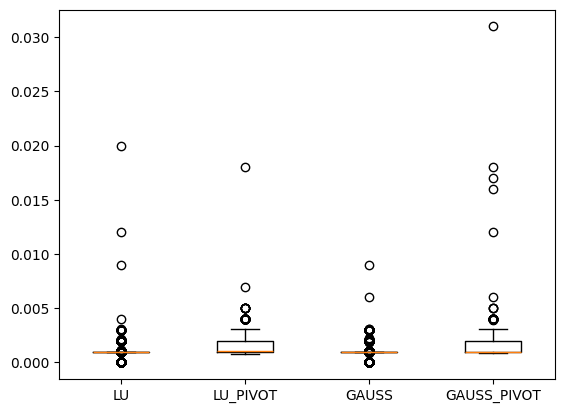

In [139]:
import matplotlib.pyplot as plt


plt.boxplot(
    [
        np.array(data_lu).reshape(1, -1)[0],
        np.array(data_pivot_lu).reshape(1, -1)[0],
        np.array(data_gauss).reshape(1, -1)[0],
        np.array(data_gauss_pivot).reshape(1, -1)[0],
    ],
    labels=["LU", "LU_PIVOT", "GAUSS", "GAUSS_PIVOT"],
)

C:\Users\admin\AppData\Local\Temp\ipykernel_29452\2739259366.py:1: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


{'whiskers': [<matplotlib.lines.Line2D at 0x1d285196ae0>,
 'caps': [<matplotlib.lines.Line2D at 0x1d285195c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d285196870>,
 'medians': [<matplotlib.lines.Line2D at 0x1d285197560>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d285197890>,
 'means': []}

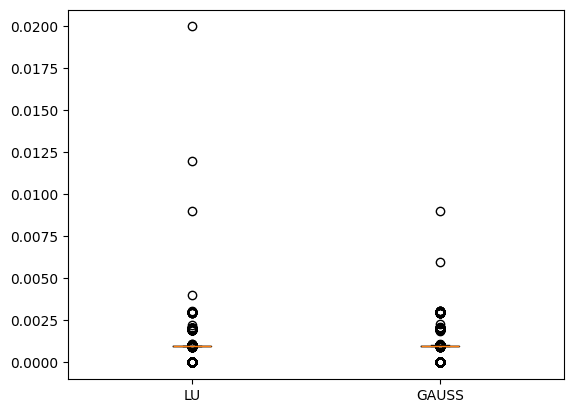

In [140]:
plt.boxplot(
    [
        np.array(data_lu).reshape(1, -1)[0],
        np.array(data_gauss).reshape(1, -1)[0],
    ],
    labels=["LU", "GAUSS"],
)